In [4]:
!pip install langchain-core langchain-openai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 21.4 MB/s eta 0:00:00


###**0. API Keys**

In [2]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
api_key = userdata.get('openai_api_key')
NEWS_API_KEY = userdata.get('news_api_key')
OPENWEATHER_API_KEY = userdata.get('openweather_api_key')

###**1. Initialize the Language Model**

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=api_key)

###**2. Define the Tools**

In [6]:
from langchain_core.tools import tool
import httpx
import urllib.parse

@tool
def fetch_and_summarize_news(arg: str = None) -> str:
    """Fetch the latest news articles and summarize them."""
    try:
        # Fetch news
        url = f"https://newsapi.org/v2/top-headlines?sources=bbc-news&apiKey={NEWS_API_KEY.strip()}"

        response = httpx.get(url)
        response.raise_for_status()
        articles = response.json().get("articles", [])

        if not articles:
            return "No news articles found."

        # Prepare articles for summarization
        sanitized_articles = []
        for article in articles:
            title = (article.get('title') or '').replace('\n', ' ').replace('\r', ' ')
            description = (article.get('description') or '').replace('\n', ' ').replace('\r', ' ')
            sanitized_articles.append(f"Title: {title}\nDescription: {description}")

        news_text = "\n\n".join(sanitized_articles)
        prompt = f"Summarize the following news articles:\n\n{news_text}. Please do not write the title. The summary should be in point for top 3 news."

        # Generate the summary
        summary = llm.invoke(prompt)
        return summary
    except Exception as e:
        return f"Error: {e}"

@tool
def fetch_and_review_weather(city: str) -> str:
    """Fetch the weather information for a given city and generate a review."""
    city = city.strip()  # Ensure no leading/trailing spaces

    # Encode the city name for the URL
    encoded_city = urllib.parse.quote(city)
    url = f"https://api.openweathermap.org/data/2.5/weather?q={encoded_city}&appid={OPENWEATHER_API_KEY}&units=metric"

    try:
        response = httpx.get(url)
        response.raise_for_status()
        weather_data = response.json()

        # Extract weather details
        weather = weather_data['weather'][0]['main']
        temperature = weather_data['main']['temp']

        # Generate the review
        input_text = f"The current weather in {city} is {weather} with a temperature of {temperature}°C. As an expert in weather forecast analysis, please provide an appropriate weather review in 30 words."
        input_text = ''.join(c for c in input_text if c.isprintable())

        # Generate the review using the language model
        review = llm.invoke(input_text)
        return review
    except Exception as e:
        return f"Error: {e}"


In [7]:
tools = [fetch_and_review_weather, fetch_and_summarize_news]
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=api_key).bind_tools(tools)

###**3. Define Nodes and Routing Logic**

In [8]:
from typing import Literal
from langgraph.graph import END, START, StateGraph, MessagesState

def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

###**4. Build the LangGraph**

In [9]:
from langgraph.prebuilt import ToolNode

workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)


workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")
graph = workflow.compile()

###**5. Visualize the Graph**

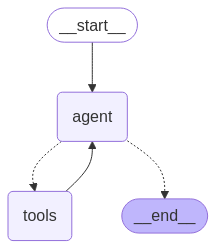

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

###**6. Run the Graph**

In [11]:
from langchain_core.messages import HumanMessage

In [12]:
message1 = [HumanMessage(content="What's the weather like in Mumbai and any major news today?")]

In [13]:
messages1 = [HumanMessage(content="Define program")]

In [14]:
msg = [HumanMessage(content="What's the weather like in Delhi and any major news of Delhi today?")]

In [15]:
result = graph.invoke({"messages": msg})
last_message = result["messages"][-1]

###**7. Display Output**

In [28]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AIMessage

if isinstance(last_message, AIMessage):
    parser = StrOutputParser()
    parsed_output = parser.parse(last_message.content)
    print("Parsed Output:", parsed_output)


Parsed Output: It appears that I'm still having trouble retrieving the weather and news information for Delhi. Unfortunately, I cannot provide the latest updates at this moment.

Please try again later, or if you have any other questions or requests, feel free to let me know!
